### Import modules

In [392]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### 1) Reading the MRI image

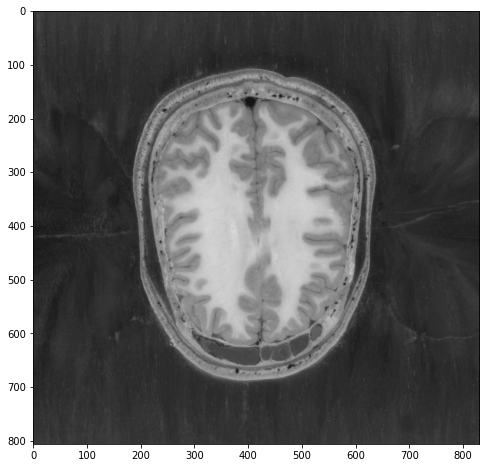

In [393]:
img = cv2.imread("Color_MRI.png", cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='gray', vmin=0, vmax=255);

### 2) Choosing seed points

First, we choose 2 points as a seed for gray and white matter of the brain:

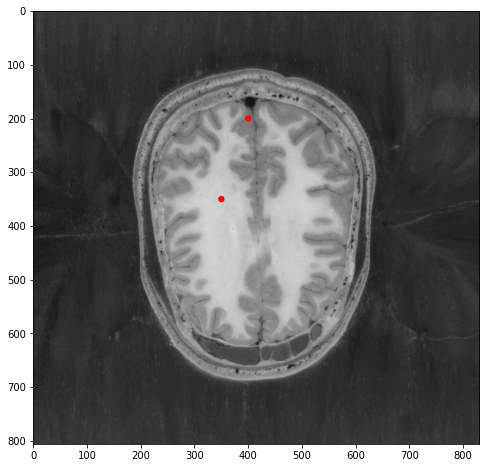

In [394]:
white_seed = (350, 350)
grey_seed = (400, 200)
img_with_seeds = img.copy()

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img_with_seeds, cmap='gray', vmin=0, vmax=255);
ax.add_patch(plt.Circle(white_seed, 5, color = 'r'))
ax.add_patch(plt.Circle(grey_seed, 5, color = 'r'))

### 3) Creating an empty image with seed points

Now we can create an empty image containing our seed points. Notice that our seed points are based on matplotlib coordinates which is not as open cv coordinates.

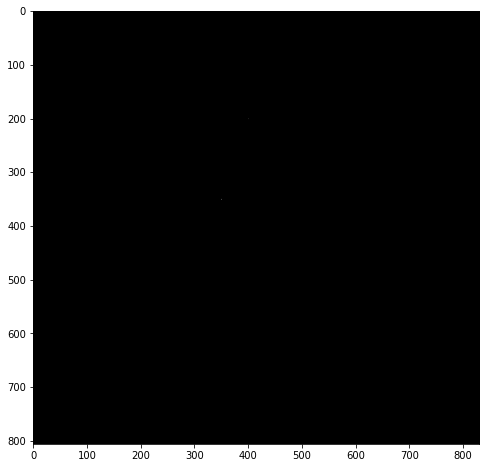

In [395]:
seed_image = np.zeros(img.shape, dtype=np.uint8)
seed_image[white_seed[1], white_seed[0]] = 255
seed_image[grey_seed[1], grey_seed[0]] = 100

plt.figure(figsize = (8, 8))
plt.imshow(seed_image, cmap='gray', vmin=0, vmax=255);

### 4, 5) Region growing function using morphological operations

Now, we can implement our region growing function. We use 4-connected components to define neighborhood.

There is a variable called `mode` in our function which can accept the following values:
- 'constant': The threshold value is the intensity of the seed value.
- 'average': The threshold valie is the average intensity of all pixels in a segment.
  
Another value called `diff` specifies maximum intensity difference from threshold.

In [396]:
import math

def is_valid(shape, x, y):
    return x >= 0 and x < shape[0] and y >= 0 and y < shape[1]

def region_growing(img, seed_image, seed_value, mode = 'constant', diff = 10):
    current_seed_image = np.zeros(img.shape, dtype=np.uint8)
    steps = 0
    # looping over the image to find the seed element
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # check if there is a seed point and not visited
            if seed_image[i, j] == 0 or seed_image[i, j] != seed_value:
                continue

            current_seed_image[i, j] = 1
            thresh = img[i, j]
            element = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
            resume = True
            while resume:
                # dialate the current seed image
                expanded_img = cv2.dilate(current_seed_image, element, iterations=1)
                # get the neighbors
                neighbors = np.subtract(expanded_img, current_seed_image)
                # check if the neighbors are valid
                neighbors = neighbors * np.uint8(np.abs(np.subtract(img, thresh, dtype=np.float32)) < diff)
                # add the neighbors to the current seed image
                current_seed_image = np.add(current_seed_image, neighbors)
                
                if np.count_nonzero(neighbors) == 0:
                    resume = False
                if mode == 'average':
                    thresh = np.sum(np.multiply(img, current_seed_image)) / np.count_nonzero(current_seed_image)
                steps += 1

            break
    return current_seed_image, steps
                    



### 6) Performing the function:

Now we can apply the function to get the segmented images. We run the function 4 times with different values of `mode` and for each mode we run the function with different values of seed_value to get the results for both gray and white matter.

#### Average mode:

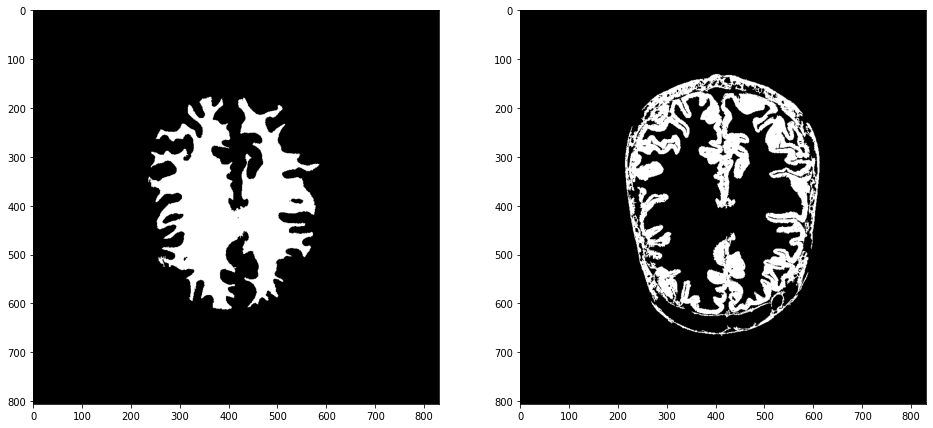

In [397]:
white_segment_avg, steps_white_avg = region_growing(img, seed_image, seed_value=255, mode= "average", diff = 35)
gray_segment_avg, steps_gray_avg = region_growing(img, seed_image, seed_value=100, mode= "average", diff = 15)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(white_segment_avg, cmap='gray');
ax[1].imshow(gray_segment_avg, cmap='gray');

plt.show();

#### Normal mode:

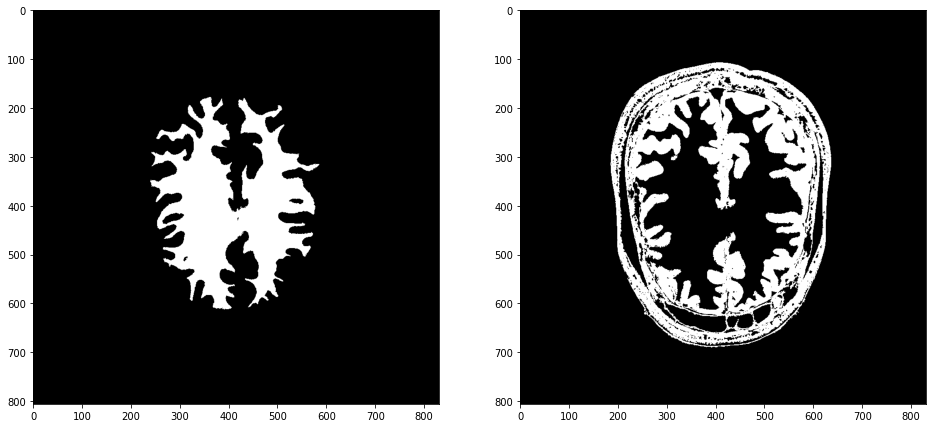

In [398]:
white_segment, steps_white = region_growing(img, seed_image, seed_value=255, diff = 50)
gray_segment, steps_gray = region_growing(img, seed_image, seed_value=100, diff = 30)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(white_segment, cmap='gray');
ax[1].imshow(gray_segment, cmap='gray');

plt.show();

### 7) Steps

In [399]:
print("White matter average: ", steps_white_avg)
print("White matter normal: ", steps_white)
print("Gray matter average: ", steps_gray_avg)
print("Gray matter normal: ", steps_gray)

White matter average:  470
White matter normal:  464
Gray matter average:  1409
Gray matter normal:  963


### 8) Comparing the results

First, we plot the results together with the original image:

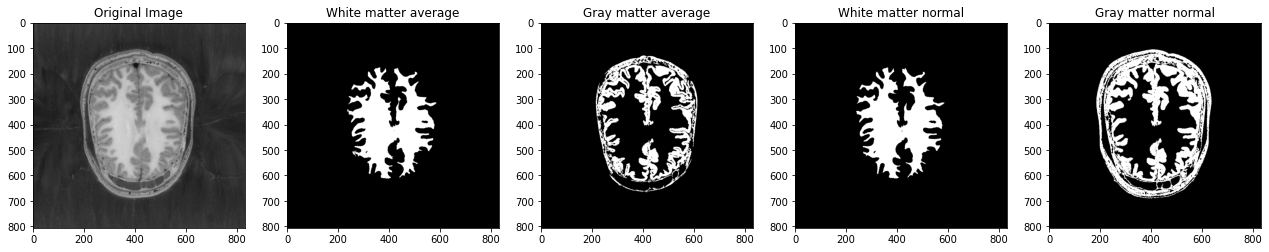

In [401]:
fig, ax = plt.subplots(1, 5, figsize=(22, 5))

ax[0].imshow(img, cmap='gray', vmin=0, vmax=255);
ax[0].set_title("Original Image")

ax[1].imshow(white_segment_avg, cmap='gray');
ax[1].set_title("White matter average")

ax[2].imshow(gray_segment_avg, cmap='gray');
ax[2].set_title("Gray matter average")

ax[3].imshow(white_segment, cmap='gray');
ax[3].set_title("White matter normal")

ax[4].imshow(gray_segment, cmap='gray');
ax[4].set_title("Gray matter normal")

plt.show();

We can get following results:

1. Using average mode it was easier to segment the gray matter and seperate it from cerebral spinal fluid(The membrane). 

2. The results for white matter are approximately the same for both modes altough I've used different diff values for each mode.

3. The average mode needs more iterations to get the results because the difference from average intensity for distant pixels is less than the difference from the seed value.